<a href="https://colab.research.google.com/github/NailKhelifa/TUM_research_project/blob/main/Continuous_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [ ]:
# Data preparation : construction of datasets that consists in the returns of 200 S&P500 stocks over the period 2001-2023

stock_symbols = ["AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "TSLA", "META", "BRK.B", "UNH", "JPM", "JNJ", "XOM", "V", "PG", "AVGO", "LLY", "HD", "MA", "CVX", "MRK", "ABBV", "PEP", "COST", "ADBE", "KO", "WMT", "BAC", "CSCO", "MCD", "TMO", "CRM", "ACN", "PFE", "NFLX", "CMCSA", "ABT", "LIN", "AMD", "ORCL", "DHR", "WFC", "DIS", "TXN", "PM", "CAT", "INTC", "NEE", "UNP", "INTU", "COP", "VZ", "LOW", "NKE", "QCOM", "UPS", "IBM", "BA", "BMY", "HON", "SPGI", "AMAT", "RTX", "AMGN", "GE", "SBUX", "GS", "MS", "DE", "NOW", "PLD", "MDT", "ELV", "ISRG", "BLK", "BKNG", "ADP", "MDLZ", "LMT", "T", "TJX", "AXP", "SCHW", "ADI", "CVS", "MMC", "GILD", "LRCX", "SYK", "VRTX", "C", "AMT", "ETN", "CI", "CB", "ZTS", "REGN", "SLB", "MO", "TMUS", "FI", "EOG", "BDX", "MU", "PGR", "SO", "BSX", "CME", "PANW", "PYPL", "EQIX", "DUK", "ITW", "KLAC", "SNPS", "CSX", "ATVI", "AON", "SHW", "CL", "NOC", "CDNS", "ICE", "APD", "FCX", "FDX", "TGT", "HUM", "WM", "MMM", "MCK", "MPC", "ORLY", "HCA", "NXPI", "USB", "EMR", "PXD", "PH", "PNC", "CMG", "MCO", "APH", "ROP", "MAR", "NSC", "GM", "F", "GD", "PSX", "MCHP", "FTNT", "CARR", "EW", "MSI", "AJG", "TT", "DXCM", "ADM", "TDG", "AZO", "VLO", "CCI", "PSA", "OXY", "SRE", "ECL", "TEL", "AIG", "ON", "PCAR", "MNST", "ANET", "CHTR", "GIS", "ADSK", "STZ", "NUE", "MSCI", "KMB", "CTAS", "COF", "TFC", "JCI", "AFL", "D", "HEC", "IDXX", "AEP", "WMB", "WELL", "MET", "EXC", "HLT", "IQV", "PAYX", "EL", "CTVA", "O", "TRV", "ROST"]
start_date1 = "2001-01-01"
end_date1 = "2023-07-01"
data = pd.DataFrame(yf.download(tickers=stock_symbols, start=start_date1, end=end_date1))
log_returns = pd.DataFrame(np.log(data["Close"]/data["Open"]).transpose())

# First month data

start1 = "2023-01-01"
end1 = "2023-02-01"
data = pd.DataFrame(yf.download(tickers=stock_symbols, start=start1, end=end1))
X_1 = pd.DataFrame(np.log(data["Close"]/data["Open"]).transpose())
X_1 = X_1.dropna()

[*********************100%%**********************]  200 of 200 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['HEC', 'BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  200 of 200 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['HEC', 'BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [ ]:
def similarity(n_repeat, data, n_components, cov_type):



  '''
  arguments:

  n_repeat:       integer                  ---> represents the number of time we repeat the clustering
  data:           pandas DataFrame         ---> contain the data we train the model and make our predictions with
  n_components:   integer                  ---> represents the number of clusters we fix in our model
  cov_type:       string                   ---> represents the shape of the covariance matrix ('spherical', 'diagonal', 'full', 'tied')

  '''

  ################ STEP 1: create a pandas DataFrame of shape (number_of_stocks, n_repeat) which elements are numpy arrays of length n_components
  ################         that represent for a given stock the probability that it belongs to one of the clusters

  number_of_stocks = len(data.index)
  model = GaussianMixture(n_components=n_components, covariance_type=cov_type)
  model.fit(data)
  column_names = ['cluster %i'%(i+1) for i in range(n_components)]
  index_Y = ['rep n°%i' %i for i in range(n_repeat)]
  Y = pd.DataFrame(index=index_Y, columns=data.index)
  S = data.index.tolist()
  for i in range(n_repeat):
    predict_proba_i = pd.DataFrame(model.predict_proba(data), index=data.index, columns=column_names)
    for j in range(number_of_stocks):
      Y.iloc[i][j] = predict_proba_i.iloc[j]

  print("------ STEP_1 COMPLETED ------")

  ################ STEP 2: We define a similarity measure same_cluster_proba that takes two integers (that represent the indices of each of the stocks)
  ################         and returns the probability that they belong to the same cluster based on the probabilities given in the dataframe
  ################         previously created. More precisely, we define this measure by multipling the probabilities of belonging to each clusters
  ################         for all stocks and then by taking the sum of it.

  def same_cluster_proba(i, j):
    mean = np.array([])
    for k in range(n_repeat):
      mean_k = np.sum(Y.iloc[k][i]*Y.iloc[k][j])
      mean = np.append(mean, mean_k)

    return np.mean(mean) ## we take the average probability over that stock i and j belong to the same
                         ## cluster over all cluster repetitions

  print("------ STEP_2 COMPLETED ------")

  ################ STEP 3: We now create a similarity_matrix by using the previous dataframe Y and the similarity measure we defined with
  ################         same_cluster_proba. We iterate over couples of stocks

  similarity_matrix = pd.DataFrame(np.zeros((number_of_stocks, number_of_stocks)), index=data.index, columns=data.index).transpose()
  for i in range(number_of_stocks):
    for j in range(i, number_of_stocks):
      similarity_matrix.iloc[i][j] = same_cluster_proba(i, j)

  return similarity_matrix
  print("------ STEP_3 COMPLETED ------")

  ################ STEP 4: In this step, given the similarity_matrix previously defined we construct a pandas DataFrame of shape (number_of_stocks, number_of_stocks)
  ################         filled with 1 (if the two corresponding stocks are in the same cluster) and 0 (if not). We select the precision of this matrix
  ################         to be eps = 0.92

  ### we stop here for the moment --> idea: use spectral method/hierarchichal clustering

  ## I looked for clustering algorithms that cluster data points based on a similarity matrix. I found that spectral clustering and hierarchical clustering
  ## were two easy algorithms to do so (all the more that they are already implemented on sklearn so I tried them)


In [ ]:
## fixing the parameters for the similarity function

n_repeat = 15
n_components = 5
cov_type = 'spherical'
data = X_1

## computing the similarity matrix. Beware it takes some time
Y = similarity(n_repeat=n_repeat, data=data, n_components=n_components, cov_type=cov_type).round(2)

------ STEP_1 COMPLETED ------
------ STEP_2 COMPLETED ------


In [ ]:
Y ## strange --> some stocks are not very related with themselves ? (ex: ZTS, WMT)

,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEP,...,VLO,VRTX,VZ,WELL,WFC,WM,WMB,WMT,XOM,ZTS
AAPL,0.94,0.0,0.0,0.97,0.97,0.97,0.0,0.72,0.96,0.90,...,0.0,0.01,0.0,0.96,0.03,0.00,0.00,0.30,0.00,0.04
ABBV,0.00,1.0,1.0,0.00,0.00,0.00,0.0,0.01,0.00,0.07,...,0.0,0.00,0.0,0.00,0.00,1.00,0.03,0.69,0.00,0.00
ABT,0.00,0.0,1.0,0.00,0.00,0.00,0.0,0.01,0.00,0.07,...,0.0,0.00,0.0,0.00,0.00,1.00,0.03,0.69,0.00,0.00
ACN,0.00,0.0,0.0,1.00,1.00,1.00,0.0,0.74,0.99,0.93,...,0.0,0.01,0.0,0.99,0.00,0.00,0.00,0.31,0.00,0.01
ADBE,0.00,0.0,0.0,0.00,1.00,1.00,0.0,0.74,0.99,0.93,...,0.0,0.01,0.0,0.99,0.00,0.00,0.00,0.31,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WM,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.99,0.03,0.69,0.00,0.00
WMB,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.93,0.02,0.96,0.10
WMT,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.57,0.00,0.00
XOM,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,1.00,0.10


Main problem from now on: how to recover cluster given this similarity matrix ? We have computed "weights" (probability) of a stock being in the same cluster than another one --> considering several levels of belonging to a cluster ?  

In [ ]:
## We now use the AgglomerativeClustering algorithm (sklearn's implementation of hierarchical clustering) to recover clusters
## based on this similarity matrix

## Problem: how to cluster given this similarity matrix

n_clusters = 5
affinity = "precomputed"
linkage = 'average'
metric = 'precomputed'
hierarchy = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=metric)

hierarchy.fit(Y)

AgglomerativeClustering(linkage='average', metric='precomputed', n_clusters=5)

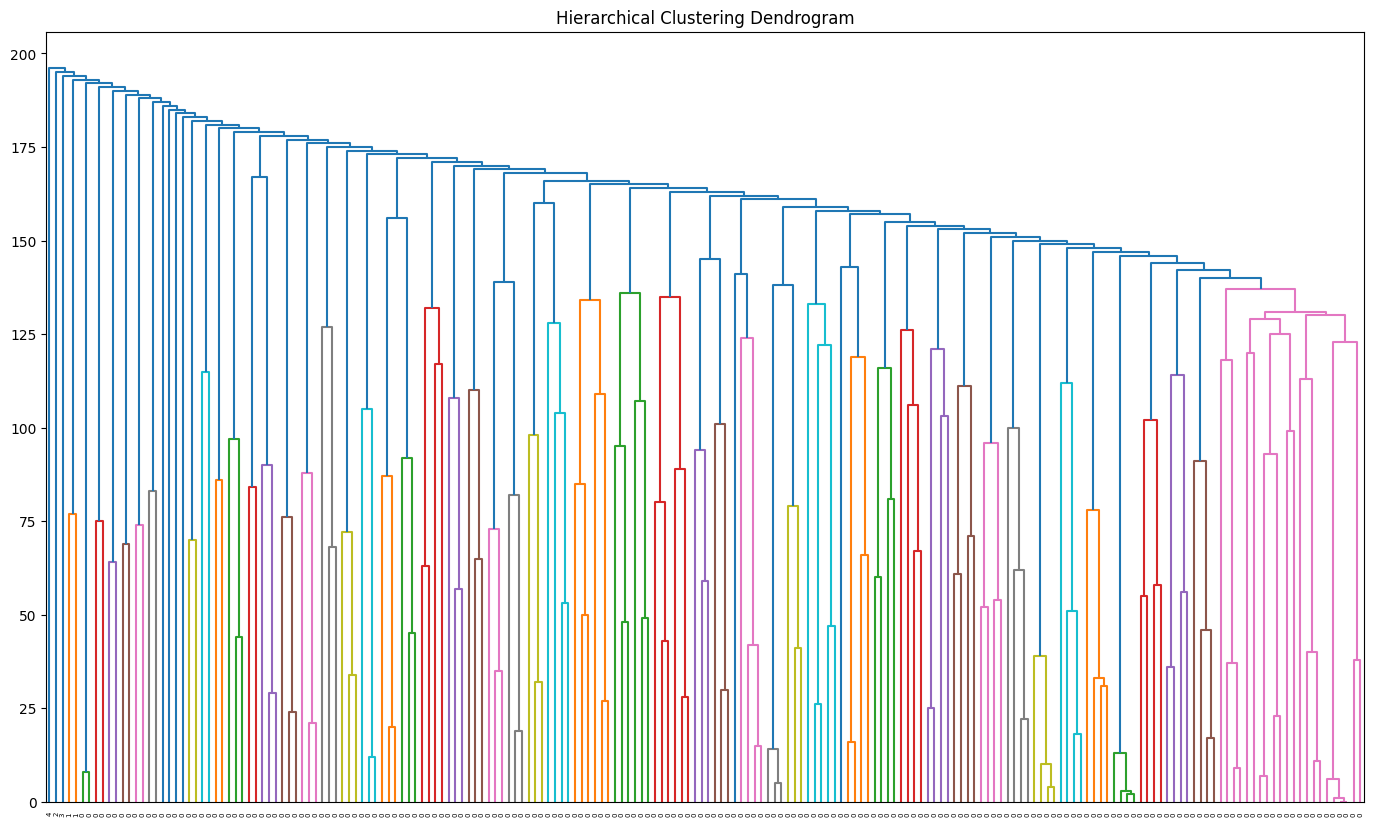

In [ ]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

fig, ax = plt.subplots(figsize=(17, 10))

ax.set_title('Hierarchical Clustering Dendrogram')
ax.margins(x=0.1)
plot_dendrogram(hierarchy, labels=hierarchy.labels_)
plt.show()

In [ ]:
## We now try to use the DBSCAN algorithm which also can be fitted on a "precomputed" similarity matrix
'''
DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
Finds core samples of high density and expands clusters from them.
Good for data which contains clusters of similar density.

Arguments:

- eps :: float, default=0.5
The maximum distance between two samples for one to be considered as in the neighborhood of the other.
This is not a maximum bound on the distances of points within a cluster.
This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

- min_samplesint, default=5
The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

- metricstr, or callable, default=’euclidean’
The metric to use when calculating distance between instances in a feature array.
If metric is “precomputed”, X is assumed to be a distance matrix and must be square.
'''



density_clusters = DBSCAN(eps = 0.75, min_samples=20, metric="precomputed")

density_clusters.fit(Y) ## ---> ?

DBSCAN(eps=0.75, metric='precomputed', min_samples=20)